## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3036460/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3036460/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3036460/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3036460/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3036460/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3036460/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3036460/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

In [0]:
# # Delete Bronze Delta Table
# dbutils.fs.rm("/tmp/labuser104917-3036460/bronze.delta", recurse=True)

# # Delete Bronze Checkpoint Directory
# dbutils.fs.rm("/tmp/labuser104917-3036460/bronze.checkpoint", recurse=True)

# # Delete Silver Delta Table
# dbutils.fs.rm("/tmp/labuser104917-3036460/silver.delta", recurse=True)

# # Delete Silver Checkpoint Directory
# dbutils.fs.rm("/tmp/labuser104917-3036460/silver.checkpoint", recurse=True)

# # Delete Gold Delta Table
# dbutils.fs.rm("/tmp/labuser104917-3036460/gold.delta", recurse=True)

# # Delete Gold Checkpoint Directory
# dbutils.fs.rm("/tmp/labuser104917-3036460/gold.checkpoint", recurse=True)

Out[9]: True

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")

In [0]:
import numpy as np
import pandas as pd
import time

from delta.tables import DeltaTable
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType

import torch
import transformers
import mlflow
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# List the files in the source directory
file_list = get_source_listing_df()
file_list

,File Name
0,voc_volume/0.json
1,voc_volume/1.json
2,voc_volume/10.json
3,voc_volume/100.json
4,voc_volume/1000.json
...,...
199996,voc_volume/99995.json
199997,voc_volume/99996.json
199998,voc_volume/99997.json
199999,voc_volume/99998.json


In [0]:
# Count the number of files
file_list.count()

Out[10]: File Name    200001
dtype: int64

In [0]:
# Print the contents of one of the files
print(show_s3_file_contents('voc_volume/1.json'))

b'{"date": "Mon Apr 06 22:19:49 PDT 2009", "user": "scotthamilton", "text": "is upset that he can\'t update his Facebook by texting it... and might cry as a result  School today also. Blah!", "sentiment": "negative"}'


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
#  define the schema
raw_schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("source_file", StringType(), False),
    StructField('processing_time', TimestampType(), False)
])

raw_df = (
    spark
    .readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")  # Specify the format of the files in the storage
    .option("path", TWEET_SOURCE_PATH)
    .option("mergeSchema", "true")
    .schema(raw_schema)  # Apply the schema defined
    .load()  
)

# Transform the raw data to add processing_time and source_file (if not included in raw data)
raw_df = raw_df.withColumn("source_file", input_file_name())
raw_df = raw_df.withColumn("processing_time", current_timestamp())

In [0]:
# Setup the write stream with the defined checkpoint location and table path
bronze_stream = (raw_df
                 .writeStream
                 .format("delta")
                 .outputMode("append")
                 .option("checkpointLocation", BRONZE_CHECKPOINT)
                 .option("mergeSchema", "true")
                 .trigger(processingTime="10 seconds") 
                 .queryName("bronze_stream")
                 .start(BRONZE_DELTA))

In [0]:
bronze_stream.awaitTermination()

In [0]:
print(bronze_stream.status)  # Check the status of stream

{'message': 'Getting offsets from CloudFilesSource[s3a://voc-75-databricks-data/voc_volume/]', 'isDataAvailable': False, 'isTriggerActive': True}


In [0]:
bronze_df = spark.read.format("delta").load(USER_DIR+"bronze.delta")
display(bronze_df.limit(5))

date,user,text,sentiment,source_file,processing_time
Fri May 01 21:30:59 PDT 2009,PenutButrToast,"@RuthCollins Haven't caught the new video yet...the new song doesn't quite beat ""You're not sorry"" for me. Checked out your music - nice!",positive,s3a://voc-75-databricks-data/voc_volume/102869.json,2024-05-11T16:56:14.012+0000
Fri May 01 21:35:51 PDT 2009,rashaancruze,"I've decided to start twittering uplifting quotes that inspire me from ""The Alchemist"", author Wayne Dyer, Louise Hay, Deepak Chopra etc.",positive,s3a://voc-75-databricks-data/voc_volume/103018.json,2024-05-11T16:56:14.012+0000
Fri May 01 21:40:37 PDT 2009,MichaelJMeyer,�To be yourself in a world that is constantly trying to make you something else is the greatest accomplishment.� Ralph Waldo Emerson.,positive,s3a://voc-75-databricks-data/voc_volume/103124.json,2024-05-11T16:56:14.012+0000
Fri May 01 21:30:39 PDT 2009,tuxedopants,"@skeena00 I went to Cap, lived in C-bus for 7 yrs & got OSU tattoo days before moving to LA. A friend reps Hugh Jackman & I just can't...",positive,s3a://voc-75-databricks-data/voc_volume/102816.json,2024-05-11T16:56:14.012+0000
Fri May 01 21:30:46 PDT 2009,robogoose,"Hey!!! www.themediamall.com playon is working great now, well at ""low"" setting only. Hey I'm just happy I'm getting streaming media, yeah",positive,s3a://voc-75-databricks-data/voc_volume/102836.json,2024-05-11T16:56:14.012+0000


## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
tweet_count = bronze_df.count()
print(f"Total number of tweets: {tweet_count}")

Total number of tweets: 200000


In [0]:
# Check if there exists colunmns containing nan or null values
missing_values = bronze_df.select([count(when(isnan(col(c).cast("double")) | col(c).isNull(), c)).alias(c) for c in bronze_df.columns])
missing_values.show()

+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [0]:
tweets_by_ueser = bronze_df.groupBy('user').count().orderBy(desc('count'))
tweets_by_ueser.show()

+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  310|
|     nuttychris|  129|
|      iHomeTech|   81|
|       tsarnick|   77|
| Hollywood_Trey|   71|
|  divxdownloads|   68|
|      lesley007|   65|
|  redrobinrockn|   58|
|    MissxMarisa|   57|
|     SarahSaner|   56|
|     sebby_peek|   55|
|        kasey79|   54|
|torilovesbradie|   51|
|    whitsundays|   51|
|         keza34|   49|
| MiDesfileNegro|   48|
|        Dogbook|   47|
|   TraceyHewins|   46|
|    effingcards|   43|
|         Djalfy|   43|
+---------------+-----+
only showing top 20 rows



In [0]:
# Count tweets with and without mentions
tweets_with_mentions = bronze_df.filter(col("text").contains("@")).count()
tweets_without_mentions = tweet_count - tweets_with_mentions

print(f"Tweets with mentions: {tweets_with_mentions}")
print(f"Tweets without mentions: {tweets_without_mentions}")

Tweets with mentions: 93817
Tweets without mentions: 106183


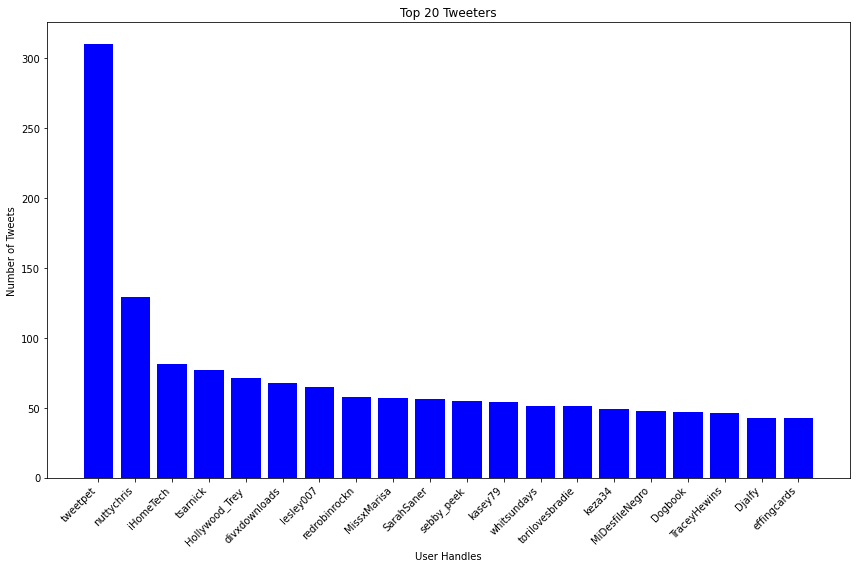

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
top_tweeters = tweets_by_ueser.limit(20).toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top_tweeters['user'], top_tweeters['count'], color='blue')
plt.xlabel('User Handles')
plt.ylabel('Number of Tweets')
plt.title('Top 20 Tweeters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
# Setup the read stream for the Bronze Delta table
bronze_df = (spark
             .readStream
             .format('delta')            
             .load(BRONZE_DELTA))

In [0]:
bronze_cleaned_df = bronze_df.withColumn("cleaned_text", regexp_replace(col("text"), r'@\w+', ""))

silver_df = bronze_cleaned_df.select(
    col('date').alias('timestamp'),
    col('text').contains('@').cast('integer').alias('mention'),
    col('cleaned_text'), 
    col('sentiment')    )

In [0]:
# Setup the stream to write to the Silver Delta table
silver_stream = (
    silver_df
    .writeStream
    .format("delta")
    .outputMode("append")
    # .trigger(once=True)
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .option("path", SILVER_DELTA)
    .queryName("silver_stream") 
    .start()
)

In [0]:
silver_stream.awaitTermination()

In [0]:
# Check the status of stream
print(silver_stream.status)   

{'message': 'Waiting for next trigger', 'isDataAvailable': False, 'isTriggerActive': False}


In [0]:
silver_data = spark.read.format("delta").load(SILVER_DELTA)
silver_data.count()

Out[36]: 200000

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# Load the pretrained transformer sentiment classifier
model_uri = f"models:/{MODEL_NAME}/1"
loaded_model = mlflow.pyfunc.load_model(model_uri)

2024/05/11 22:13:05 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/11 22:13:09 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/11 22:13:09 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [0]:
@pandas_udf("score: int, label: string")

def perform_model_inference(s: pd.Series) -> pd.DataFrame:
    predictions = loaded_model.predict(s.tolist())
    return pd.DataFrame({
        "score": predictions["score"].map(lambda x: int(x * 100)).tolist(),
        "label": predictions["label"].tolist(),
    })

silver_df = spark.readStream.format("delta").load(SILVER_DELTA)
# silver_df_100 = silver_df.limit(100)

In [0]:
gold_df = (silver_df
    .withColumn("sentiment_analysis", perform_model_inference(col("cleaned_text")))
    .withColumn("predicted_score", col("sentiment_analysis.score"))  
    .withColumn("predicted_sentiment", col("sentiment_analysis.label"))
    .withColumn("sentiment_id", when(col("sentiment") == "positive", 1).otherwise(0))
    .withColumn("predicted_sentiment_id", when(col("predicted_sentiment") == "POS", 1).otherwise(0))
    .select("timestamp", "mention", "cleaned_text", "sentiment", "predicted_score", "predicted_sentiment", "sentiment_id", "predicted_sentiment_id"))

# the neutral labels are included as negative

In [0]:
gold_stream = (
    gold_df
    .writeStream
    .format("delta")
    .option("checkpointLocation", GOLD_CHECKPOINT)
    .outputMode("append")
    .trigger(processingTime="10 seconds") 
    .queryName("gold_stream")
    .start(GOLD_DELTA)
)

In [0]:
# Check the status of stream
print(gold_stream.status)

{'message': 'Waiting for next trigger', 'isDataAvailable': False, 'isTriggerActive': False}


In [0]:
gold_stream.awaitTermination() 

In [0]:
# spark.conf.set("spark.databricks.delta.formatCheck.enabled", "false")
gold_data = spark.read.format("delta").load(GOLD_DELTA)
gold_data.count()

Out[112]: 200000

In [0]:
display(gold_data.limit(10))

timestamp,mention,cleaned_text,sentiment,predicted_score,predicted_sentiment,sentiment_id,predicted_sentiment_id
Mon May 04 07:40:52 PDT 2009,1,"hilarious. so if she acts up, all you have to do is say 1 little word...""gummed up"" grosses me out; hub says it 2 torment",positive,96,NEG,1,0
Mon May 04 07:49:33 PDT 2009,0,"Oh yea,justtoblazethingsupthismorning. Thererfemaledj'swho can cut&mix w/ the best of them. Butudonthear them cuz feelings will get hurt.",negative,64,NEU,0,0
Mon May 04 07:50:07 PDT 2009,0,rise & shine people. another long day of school ahead. then math hw with Jordan? who knows.. oh I also have a big mission today too. boo,negative,51,NEG,0,0
Sat May 09 18:15:24 PDT 2009,1,If you mean backround then.. Settings>design.. scroll to the bottem and click change backround image & there ya go.,positive,92,NEU,1,0
Sat May 09 18:19:33 PDT 2009,1,"pointed out that while my convertible may have 415 horsepower, the visors ""suck ass"" and I should take it back. Immediately.",negative,97,NEG,0,0
Mon May 04 07:41:02 PDT 2009,0,hahas . dam tried . just nw got exam . don know how much i will get . . but i having fun today . with my pri sch friends until 5plus . =D,positive,78,POS,1,1
Mon May 04 07:50:15 PDT 2009,0,"Has just watched hannah montana the movie haha i cryed twise poor lil me, me n me mate got up n danced to howdown throwdown Haha its grdd",negative,90,POS,0,1
Mon May 04 07:45:51 PDT 2009,0,"$ES_F interestign setup,the FED is forced to buy bonds,whic pressures stocks,while the gvnmt spins news to raise stocks,left&right hand",positive,86,NEU,1,0
Sat May 09 18:14:50 PDT 2009,0,"Bought potted flowers for my, & JPs mom. Now I wish I had a yard so I could buy myself a bunch! I miss flower gardening terribly bad",negative,88,POS,0,1
Sat May 09 18:14:57 PDT 2009,1,And I don't get a shoutout from him Help get this to him. http://tinyurl.com/ ...,negative,85,NEG,0,0


## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
gold_data = (gold_data.withColumn("predicted_sentiment_id", col("predicted_sentiment_id").cast(DoubleType()))
                    .withColumn("sentiment_id", col("sentiment_id").cast(DoubleType())))

In [0]:
# Evaluator instance
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment_id",
    predictionCol="predicted_sentiment_id")

# Precision, recall, and F1 score
precision = evaluator.setMetricName("weightedPrecision").evaluate(gold_data)
recall = evaluator.setMetricName("weightedRecall").evaluate(gold_data)
f1 = evaluator.setMetricName("f1").evaluate(gold_data)

In [0]:
# Confusion matrix
confusion_matrix_df = gold_data.groupBy("sentiment_id").pivot("predicted_sentiment_id").count().na.fill(0)
confusion_matrix_pandas = confusion_matrix_df.toPandas()
confusion_matrix_pandas.set_index("sentiment_id", inplace=True)

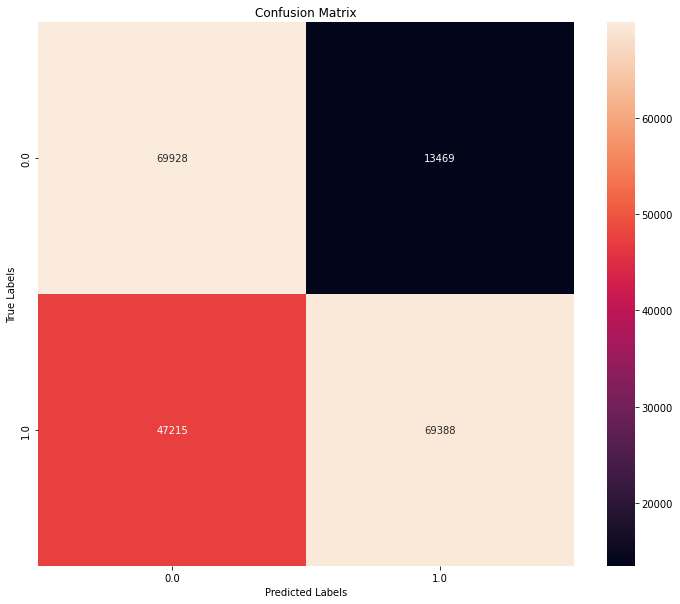

In [0]:
# Plotting confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix_pandas, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

confusion_matrix_path = '/tmp/confusion_matrix.png'
plt.savefig(confusion_matrix_path)
plt.show()

In [0]:
delta_table = DeltaTable.forPath(spark, SILVER_DELTA)
delta_version = delta_table.history().orderBy("version").select("version").collect()[-1][0]

# Run in mlflow
with mlflow.start_run():
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_artifact(confusion_matrix_path)
    # Log model name and MLflow version
    mlflow.log_param("Model Name", MODEL_NAME)
    mlflow.log_param("MLflow Version", mlflow.version.VERSION)
    # Log the Delta Table version
    mlflow.log_param("Delta Table Version", delta_version)

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
# mentions in gold
num = gold_data.filter(gold_data['mention']==1).count()
print(f"Number of mentions: {num}")

Number of mentions: 93817


In [0]:
#number of neutral, positive and negative tweets for each mention
df = (gold_data
    .withColumn('positive',when(col('sentiment') == 'positive',1).otherwise(0))
    .withColumn('negative',when(col('sentiment') == 'negative',1).otherwise(0)))

#Capture the total for each mention in a new column
result_df = (df.groupBy("mention").agg(sum("positive").alias("positive_count"), sum("negative").alias("negative_count"), count("mention").alias("total_mention")))

#Sort the mention count totals in descending order                       
result_df = result_df.orderBy(col("total_mention").desc())
result_df.show()

+-------+--------------+--------------+-------------+
|mention|positive_count|negative_count|total_mention|
+-------+--------------+--------------+-------------+
|      0|         52422|         53761|       106183|
|      1|         64181|         29636|        93817|
+-------+--------------+--------------+-------------+



<Figure size 720x576 with 0 Axes>

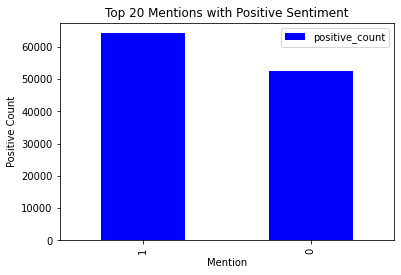

In [0]:
# Convert to Pandas DataFrame for plotting
result_pd = result_df.toPandas()

# Top 20 positive mentions
top_positive = result_pd.nlargest(20, 'positive_count')
plt.figure(figsize=(10, 8))
top_positive.plot.bar(x='mention', y='positive_count', color='blue')
plt.title('Top 20 Mentions with Positive Sentiment')
plt.xlabel('Mention')
plt.ylabel('Positive Count')
plt.show()

<Figure size 720x576 with 0 Axes>

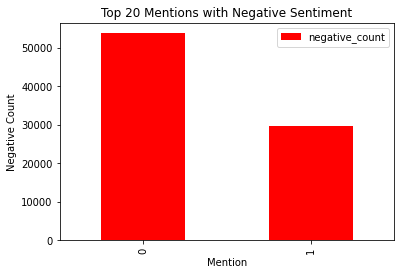

In [0]:
# Top 20 negative mentions
top_negative = result_pd.nlargest(20, 'negative_count')
plt.figure(figsize=(10, 8))
top_negative.plot.bar(x='mention', y='negative_count', color='red')
plt.title('Top 20 Mentions with Negative Sentiment')
plt.xlabel('Mention')
plt.ylabel('Negative Count')
plt.show()

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
active_streams = spark.streams.active
for stream in active_streams:
    print(f"Stream Name: {stream.name}") # streams that are running
    stream.stop() # Stop all active streams

Stream Name: gold_stream


In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()

In [0]:
#print out the elapsed time of your notebook
print(START_TIME)
print(END_TIME)
print((END_TIME-START_TIME)/60)

1715465548.1588447
1715477517.5174203
199.48930959304172


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

Spill: I could observe any spill information during the whole process, the memory allocation to executors are enough.

Skew: Skew was noted where some tasks handled more data than others, but did not significantly effect the process very much.

Storage: No issues with insufficient storage were observed during the process, indicating that the storage resources allocated to the Spark job were adequate.

Serialization: Noted to increase running efficiency, particularly with the deployment of 4 parallel executors in this project.
 
Shuffle: shuffle exist that cost the streaming and reading process slower because they involves disk I/O, network I/O, and CPU overheads to serialize and deserialize the data.
https://drive.google.com/file/d/1joCmDpIthjhvSyl51Ox_3pXeLx8tkp3u/view?usp=sharing

#### URL
https://github.com/YvetteSa/dscc202-402-spring2024

#### Username 
labuser104917-3036460